# Finding Supernova Neutrinos

To date we have only managed to detect the neutrinos from one supernova, which arrived at Earth on the 23rd February 1987 and is known by the snappy name SN1987A. In this project you will investigate the feasibility of idenitfying supernova neutrino events in a new type of detector a liquid argon time-projection chamber. These detectors give incredibly high-resolution 'images' of the charged-particle tracks produced when a neutrino interacts in the detector.

The data for this mini-project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| larImages.npy | A numpy array of 10,000 100x100 pixel images |
| meta.npy | The meta information about the particles in the image |


The images show the energy deposited in the liquid argon detector in a small slice of space and time. The meta information contains the following 64 numbers  for each image. The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)

| Column | Description |
| ----------- | ----------- |
| 0 | Row number |
| 1 | Neutrino Energy (MeV) |
| 2 | Initial state particles (always 2) |
| 3 | Final state particles (varies) |
| 4-8 | Initial Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 9-13 | Initial Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 14-18 | Final Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 19-23 | Final Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| $\vdots$ | Final Particle N: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 59-63 | Final Particle 10: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |

## Machine learning tasks
1. Write a method to simulate electronic noise in the detector. The electronic noise is expected to follow a normal distribution.
2. Develop a machine learning classifier that can successfully classify 'clean' simulated neutrinos from 'empty' slices with some amount of 'electronic noise', how does your machine learning algorithm perform at differing noise levels?
3. Test your machine learning classifier on simulated neutrinos overlaid with noise, what level of additional noise starts to impact your machine learning algorithm

### Potential extensions
1. Write a method to generate noise in the 100x100 pixel images to simulate radioactive noise. This noise should be in the form of randomly placed Gaussian 'blobs' with appropriate energy. Repeat the above tests with radioactive noise. Is radioactive noise more or less of a problem than electronic noise? 
2. Write a machine learning algorithm that can determine either the electron energy or (even better) the neutrino energy. What is the best energy resolution that can be achieved by such an algorithm?
3. Write a machine learning algorithm to effectively denoise either the electronic noise or radioactive noise datasets
4. Write a machine learning algorithm to determin the number of final state particles in the image



In [1]:
# Importing all relevant modules
import numpy as np
import matplotlib.pyplot as plt 
import random
import tensorflow as tf
import keras
import keras.layers
import sklearn
from sklearn import metrics
from tqdm import tqdm

images=np.load('larImages.npy') #Load the images
meta=np.load('meta.npy')
%matplotlib inline

images.shape (10000, 100, 100)
meta.shape (10000, 64)
Number of neutrino images: 10000
Max pixel value of all neutrino images: 106.0
Row 0 corresponds to a neutrino of 21.2005 MeV and produced 6 final state particles
Row 1 corresponds to a neutrino of 21.8617 MeV and produced 3 final state particles
Row 2 corresponds to a neutrino of 17.6584 MeV and produced 4 final state particles
Row 3 corresponds to a neutrino of 20.1423 MeV and produced 5 final state particles
Row 4 corresponds to a neutrino of 23.3148 MeV and produced 5 final state particles
Row 5 corresponds to a neutrino of 26.357 MeV and produced 6 final state particles
Row 6 corresponds to a neutrino of 25.075 MeV and produced 5 final state particles
Row 7 corresponds to a neutrino of 14.2213 MeV and produced 5 final state particles
Row 8 corresponds to a neutrino of 20.3488 MeV and produced 5 final state particles
Row 9 corresponds to a neutrino of 15.3484 MeV and produced 7 final state particles


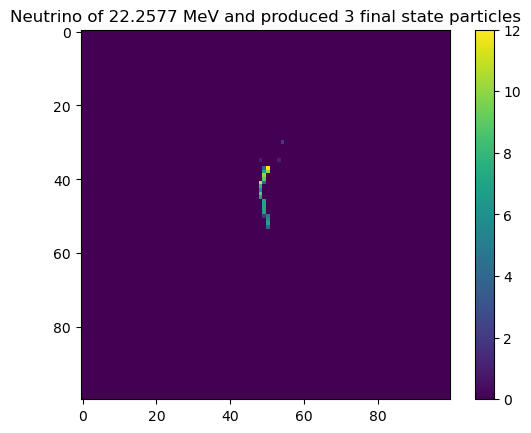

In [2]:
# Testing datashapes of loaded data

print("images.shape",images.shape)
print("meta.shape",meta.shape)

print(f'Number of neutrino images: {len(images)}')
print(f'Max pixel value of all neutrino images: {np.max(images)}')

def reaction(num):
    print("Row",int(meta[num][0]),"corresponds to a neutrino of",meta[num][1], "MeV and produced",int(meta[num][3]),"final state particles")
for i in range(10):
    reaction(i)
#print(f'Final particle slice test {meta[:,3]}')
firstimg=27
plt.figure()
plt.imshow(images[firstimg])
plt.colorbar()
plt.title(f'Neutrino of {meta[firstimg][1]} MeV and produced {int(meta[firstimg][3])} final state particles')
plt.show()

## Machine learning tasks
1. Write a method to simulate electronic noise in the detector. The electronic noise is expected to follow a normal distribution.
2. Develop a machine learning classifier that can successfully classify 'clean' simulated neutrinos from 'empty' slices with some amount of 'electronic noise', how does your machine learning algorithm perform at differing noise levels?
3. Test your machine learning classifier on simulated neutrinos overlaid with noise, what level of additional noise starts to impact your machine learning algorithm

## Task 1 - Generating noise

1. Write a method to simulate electronic noise in the detector. The electronic noise is expected to follow a normal distribution.

Here basic functions are set up to generate image arrays filled with Gaussian noise, a function that returns a list of the maximum pixel values of an input image array, a function that samples images from the neutrino image dataset, and a function that normalises arrays using min-max normalisation.

Here, noise is generated using the `np.random.normal` function which randomly samples from a Gaussian distribution centred around 0, where $\sigma$ is the variable that is changed. The generated noise array are 'clipped' at 0 to ensure that when noise images are overlaid onto neutrino images, the scale is kept above 0.

There is also a quick test of all the functions defined here.

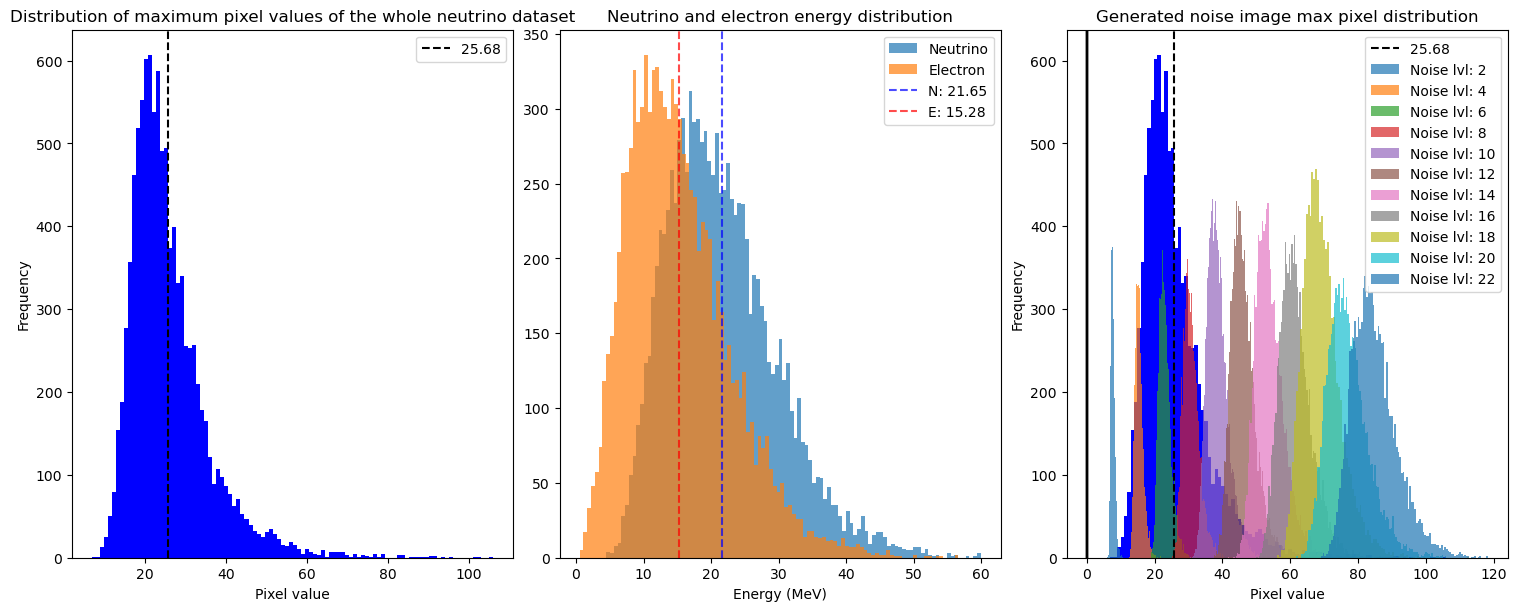

Size of noise array - Expecting (50,100,100). Got: (50, 100, 100). 
Size of image sample array: Expecting (50,100,100). Got: (50, 100, 100)


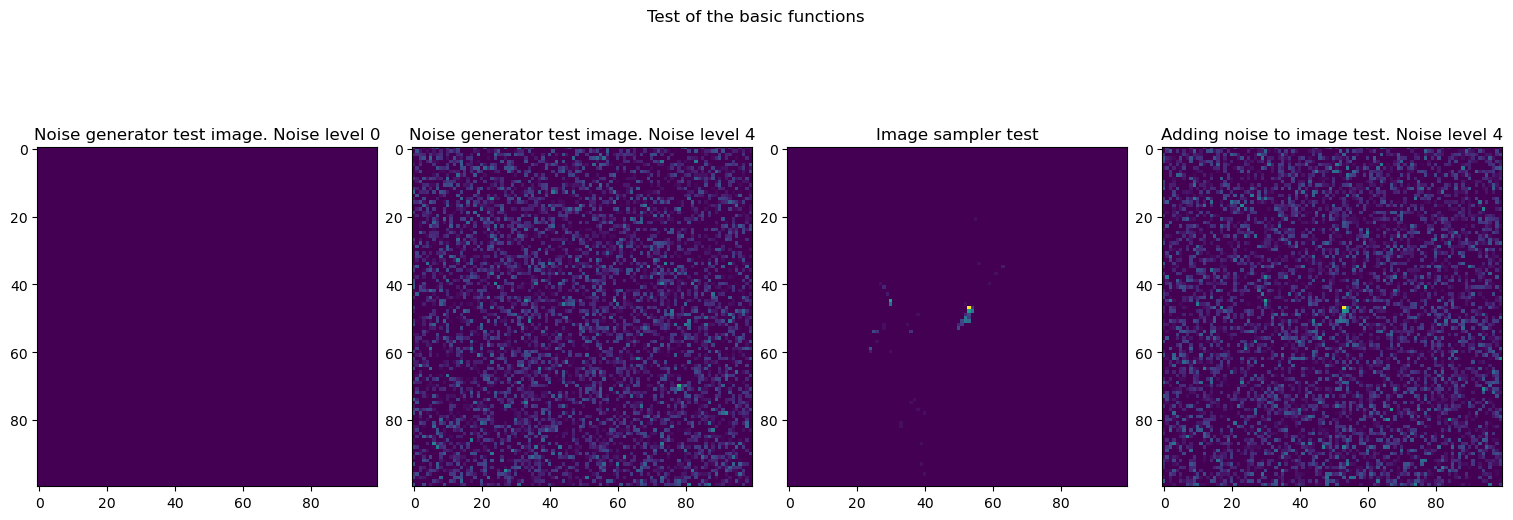

In [3]:
# Here we are just testing the required techniques and settings up some necessary functions

def maxpixelvalue(imageset):
    '''
    Returns the maximum pixel values from an image dataset

    Inputs
    - imageset - image array to loop over

    Outputs
    - max_values - list of maximum pixel from each image
    '''
    max_values = [np.max(i) for i in imageset]
    return max_values

max_values = maxpixelvalue(images)

def noise(noise):
    '''
    Generates a 100x100 2D array of normally distributed noise using np.random.normal function centred about 0

    Inputs
    - noise - some float input for the noise level

    Outputs
    - noisyimg - outputs the 100x100 noise array
    '''
    #image dimensions
    shape = (100,100)
    
    #generates array of random noise
    noisearray = np.random.normal(0, noise, size=shape)
    # clip necessary to exclude noise generated below 0
    noisyimg = noisearray.clip(min=0)
    return noisyimg

def noisearraymaker(num, noiselvl):
    '''
    Generates a list of 2D 100x100 noise arrays

    Inputs
    - num - Integer input of how many arrays to generate
    - noiselvl - Float input for the level of noise

    Outputs
    - justnoise - List array of the 2D noise arrays
    '''
    justnoise=np.empty([num, 100, 100])
    for i in range(num):
        justnoise[i] = noise(noiselvl)
    return justnoise

def imagesample(num):
    '''
    Takes a sample of images from the neutrino image dataset

    Inputs
    - num - number of images to take from the dataset

    Outputs
    - imagearray - array of images
    '''
    imagearray = images[0:num]

    return imagearray

def minmaxnorm(data):
    '''
    Performs min-max normalization on input data.

    Inputs
    - data - Input array

    Outputs:
    - normalized_data - normalized data
    '''
    # Calculate the minimum and maximum values
    min_val = np.min(data)
    max_val = np.max(data)
    
    # Perform min-max normalization
    normalized_data = (data - min_val) / (max_val - min_val)
    
    return normalized_data

# Create a histogram of maximum pixel value of neutrino dataset
fig, ax=plt.subplots(1,3, figsize=(15,6), constrained_layout=True)

ax[0].hist(max_values, bins=100, color='blue')
ax[2].hist(max_values, bins=100, color='blue')
ax[0].set_title('Distribution of maximum pixel values of the whole neutrino dataset')
ax[0].set_xlabel('Pixel value')
ax[0].set_ylabel('Frequency')
ax[0].axvline(np.mean(max_values), c='k', ls='--', label=f'{np.mean(max_values):2.2f}')
ax[2].axvline(np.mean(max_values), c='k', ls='--', label=f'{np.mean(max_values):2.2f}')
ax[0].legend()

ax[1].set_title('Neutrino and electron energy distribution')
ax[1].hist(meta[:,1], bins=100, label='Neutrino', alpha=0.7)
ax[1].hist(meta[:,15], bins=100, label='Electron', alpha=0.7)
ax[1].axvline(np.mean(meta[:,1]), c='b', ls='--', label=f'N: {np.mean(meta[:,1]):2.2f}', alpha=0.7)
ax[1].axvline(np.mean(meta[:,15]), c='r', ls='--', label=f'E: {np.mean(meta[:,15]):2.2f}', alpha=0.7)
ax[1].set_xlabel('Energy (MeV)')
ax[1].legend()

for i in np.arange(2,23,2):
    y = noisearraymaker(10000, (i))
    ax[2].hist(maxpixelvalue(y), bins=100, alpha=0.7, label=f'Noise lvl: {i}')
    ax[2].axvline(x=0, c='k')
ax[2].set_title('Generated noise image max pixel distribution')
ax[2].set_xlabel('Pixel value')
ax[2].set_ylabel('Frequency')
ax[2].legend()
plt.show()

# Testing the other functions
testnoiselevel = 4
numofimgs = 50

# 4 tests: 0 noise, some noise, image sampler test, and adding noise to image test
noisearrtestz = noisearraymaker(numofimgs, 0)
noisearrtest = noisearraymaker(numofimgs, testnoiselevel)
imgsampletest=imagesample(numofimgs)
imgsamplewnoisetest = imgsampletest+noisearraymaker(numofimgs, testnoiselevel)

print(f'Size of noise array - Expecting ({numofimgs},100,100). Got: {noisearrtest.shape}. ')

print(f'Size of image sample array: Expecting ({numofimgs},100,100). Got: {imgsampletest.shape}')

# Testing the noise functino ensuring edge cases work as expected
fig, ax=plt.subplots(1,4, figsize=(15,6), constrained_layout=True)
fig.suptitle('Test of the basic functions')
imgno = np.random.randint(0,numofimgs)
vmax = np.max(imgsamplewnoisetest[imgno])

ax[0].set_title(f'Noise generator test image. Noise level 0')
im1 = ax[0].imshow(noisearrtestz[imgno], vmax=vmax)

ax[1].set_title(f'Noise generator test image. Noise level {testnoiselevel}')
im1 = ax[1].imshow(noisearrtest[imgno], vmax=vmax)

ax[2].set_title('Image sampler test')
im2 = ax[2].imshow(imgsampletest[imgno], vmax=vmax)

ax[3].set_title(f'Adding noise to image test. Noise level {testnoiselevel}')
im3=ax[3].imshow(imgsamplewnoisetest[imgno], vmax=vmax);

### Discussion - Generating noise
Here we have tested the image array size, the distribution pixel brightness, noise pixel brightess, and how the addition of noise will affect neutrino images. From the third histogram it can be seen that generating noise above level 10 and overlaying onto neutrino images will muddle/obscure the majority of neutrino images and so the model isn't expected to perform very well above a noise level of 10.

## Preprocessing - Image normalisation

$$x_{norm}=\frac{x-x_{min}}{x_{max}-x_{min}}$$
Here we have normalised the training image dataset using the min-max normalisation technique. It involves linearly scaling the pixel values to between [0, 1] in this case. (I have moved this to the previous cell). This technique rescales pixel values without altering their relative positions ensuring that the overall structure and characteristics of the image remain unchanged, helping to preserve relative pixel brightnesses and other variations that could hold information about energies of interactions. This happens after noise is overlaid onto the images and is applied at the same scale to the 'just noise' images appended to the training dataset.

This also helps when training a binary classifier as the required activation function `sigmoid` is scale-sensitive, that is, it works best in the range [0, 1]

(1000, 100, 100) (1000, 100, 100)


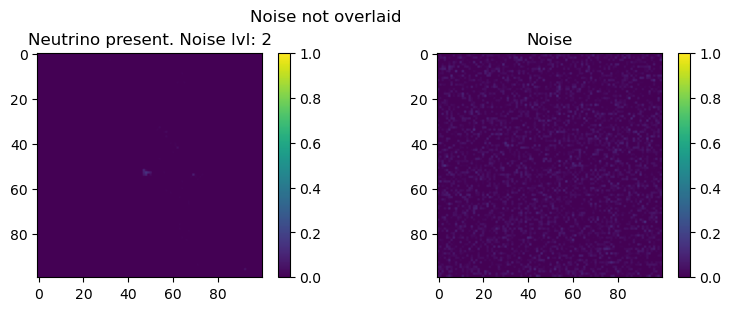

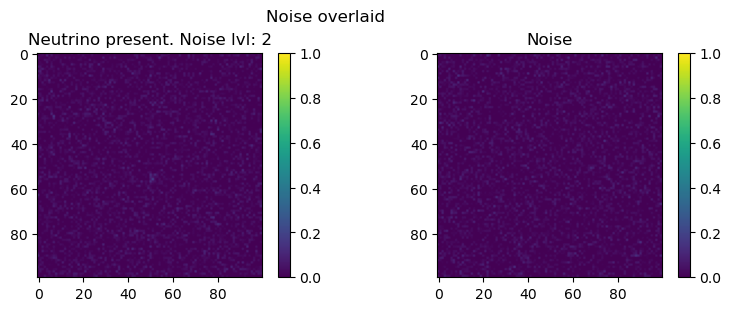

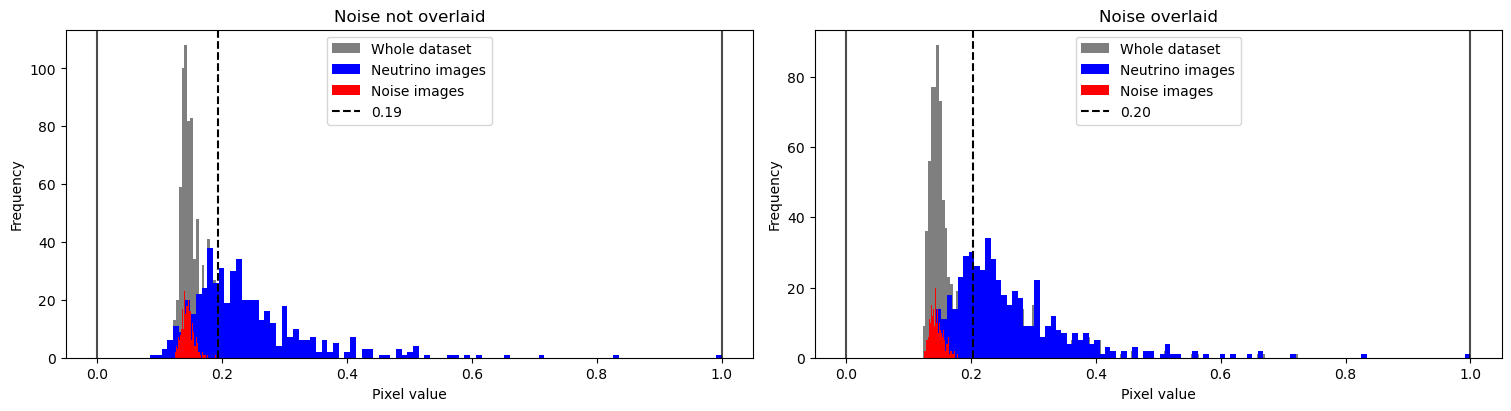

In [4]:
# Setting up and normalising the training image arrays and labels

def trainingimgmaker(numofimg, overlaid, noiselvl):
    '''
    This function generates a dataset of training images
    First half of the dataset are neutrino images over which noise can be overlaid.
    Second half of the dataset is just noise.
    Images are normalised so the model works faster.

    This also generates the associated binary labels (0 for just noise, 1 for a neutrino + noise).

    Inputs
    - numofimg - number of images needed for the dataset
    - noiselvl - how much noise to generate and add to neutrino images

    Outputs
    - trainlabel - array of 1s and 0s indicating the presence of neutrinos in images
    - trainingimages - array of noisy neutrino images and noise images

    '''
    numoftrimgs = int(numofimg/2)

    trainlabel = np.append(np.ones(numoftrimgs), np.zeros(numoftrimgs))
    trainlabel = np.array(trainlabel)

    imgsample = imagesample(numoftrimgs)
    trimgwnoise = (imgsample+noisearraymaker(numoftrimgs,noiselvl))
    trnoisearray = noisearraymaker(numoftrimgs, noiselvl)

    if noiselvl == 0:
        trainingimages = np.append(minmaxnorm(trimgwnoise), trnoisearray, axis=0)
        return trainingimages, trainlabel
    else:
        if overlaid == True:
            trainingimages = minmaxnorm(np.append(trimgwnoise, trnoisearray, axis=0))
            return trainingimages, trainlabel

        else:
            trainingimages = minmaxnorm(np.append(imgsample, trnoisearray, axis=0))
            return trainingimages, trainlabel

# Creates training image array and labels noise not overlaid
trainingimages, trainlabel = trainingimgmaker(1000, False, 4)
trainingimagesol, trainlabelol = trainingimgmaker(1000, True, 4)

print(trainingimages.shape, trainingimagesol.shape)

# Plot random image from training image dataset
fig, ax = plt.subplots(1,2, figsize=(8,3), constrained_layout=True)
fig.suptitle('Noise not overlaid')

im1 = ax[0].imshow(trainingimages[np.random.randint(0,500)], vmax=np.max(trainingimages))
ax[0].set_title(f'Neutrino present. Noise lvl: 2')

im2 = ax[1].imshow(trainingimages[np.random.randint(501, 1000)], vmax=np.max(trainingimages))
ax[1].set_title('Noise')
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
plt.show()

# Plot random image from training image dataset with noise overlaid
fig, ax = plt.subplots(1,2, figsize=(8,3), constrained_layout=True)
fig.suptitle('Noise overlaid')

im1 = ax[0].imshow(trainingimagesol[np.random.randint(0,500)], vmax=np.max(trainingimagesol))
ax[0].set_title(f'Neutrino present. Noise lvl: 2')

im2 = ax[1].imshow(trainingimagesol[np.random.randint(501, 1000)], vmax=np.max(trainingimagesol))
ax[1].set_title('Noise')
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
plt.show()

# Generate array of the maximum pixel value of each image in the training data
maxp = maxpixelvalue(trainingimages)
maxptrainimg = maxpixelvalue(trainingimages[:500])
maxpnoiseimg = maxpixelvalue(trainingimages[501:])

maxpol = maxpixelvalue(trainingimagesol)
maxptrainimgol = maxpixelvalue(trainingimagesol[:500])
maxpnoiseimgol = maxpixelvalue(trainingimagesol[501:])


# Plot histogram of maximum pixel value of neutrino dataset
fig, ax=plt.subplots(1,2, figsize=(15,4), constrained_layout=True)
for i in range(2):
    ax[i].axvline(x=0, c='k', ls='-', alpha=0.7)
    ax[i].axvline(x=1, c='k', ls='-', alpha=0.7)

ax[0].hist(maxp, bins=200, color='k', label='Whole dataset', alpha=0.5)
ax[0].hist(maxptrainimg, bins=100, color='b', label='Neutrino images')
ax[0].hist(maxpnoiseimg, bins=100, color='r', label='Noise images')
ax[0].axvline(np.mean(maxp), c='k', ls='--', label=f'{np.mean(maxp):2.2f}')
ax[0].set_title('Noise not overlaid')
ax[0].set_xlabel('Pixel value')
ax[0].set_ylabel('Frequency')
ax[0].legend()

ax[1].hist(maxpol, bins=200, color='k', label='Whole dataset', alpha=0.5)
ax[1].hist(maxptrainimgol, bins=100, color='b', label='Neutrino images')
ax[1].hist(maxpnoiseimgol, bins=100, color='r', label='Noise images')
ax[1].axvline(np.mean(maxpol), c='k', ls='--', label=f'{np.mean(maxpol):2.2f}')
ax[1].set_title('Noise overlaid')
ax[1].set_xlabel('Pixel value')
ax[1].set_ylabel('Frequency')
ax[1].legend()

### Discussion - Adding noise to neutrino images
I'm not sure why the brief wants us to train a model on neutrino images with no noise overlaid and in the same dataset have images with just noise, as having trained and tested a model with this style of training dataset (a code cell I have since removed), it achieves an accuracy of 1.0 at every noise level.

Instead, training and testing datasets are made up of neutrino images with noise added to them, and images of just noise. Here we can see the effect that electronic noise can have on the accuracy of a binary classifier.

Histograms have been plottted to illustrate how the neutrino image dataset will be affected by the addition of noise.

## Task 2 - Developing a binary classifier
2. Develop a machine learning classifier that can successfully classify 'clean' simulated neutrinos from 'empty' slices with some amount of 'electronic noise', how does your machine learning algorithm perform at differing noise levels?

Over the next few cells, a convolutional neural network (CNN) is set up, trained and tested. The model architecture is based on Krizhevsky's AlexNet and follows a similar structure of 3 convolution and pooling layers followed by a few fully-connected 'dense' layers with a single output neuron with `sigmoid` activation as this is scaled between 0 and 1. For this model to be a binary classifier, the loss function used when compiling must be `binary_crossentropy`.

In [5]:
# Setting up our model

'''model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=(100,100)))
model.add(keras.layers.Dense(40,activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(20,activation='relu'))
model.add(keras.layers.Dropout(0.25))
# Just 1 output neuron for a binary classifier
model.add(keras.layers.Dense(1, activation='sigmoid'))'''

# Alternate model based on Kirshevsky's AlexNet
model2 = keras.models.Sequential()

model2.add(keras.layers.Conv2D(16, 3, activation='relu', input_shape=(100,100,1)))
model2.add(keras.layers.MaxPooling2D((2, 2)))

model2.add(keras.layers.Conv2D(64, 3, activation='relu'))#
model2.add(keras.layers.MaxPooling2D((2, 2)))

model2.add(keras.layers.Conv2D(64, 3, activation='relu'))#
model2.add(keras.layers.MaxPooling2D((2, 2)))

model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(64,activation='relu'))
model2.add(keras.layers.Dropout(0.3))
model2.add(keras.layers.Dense(64,activation='relu'))
# Just 1 output neuron for a binary classifier
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.save_weights('./checkpoints/initial_weights')

model2.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 64)       

In [6]:
# Lists of noise to iterate over for training and testing
noiselist = np.arange(0,21,2)
noiselist2=np.arange(0,41,2)
trainaccresults = []
valaccresults = []
testaccresults = np.empty((0,len(noiselist2)))
confusionresults = []
#fptestacc = np.empty((0,len(noiselist)))

# Training and testing our model nested testing loop within a training loop
for i in noiselist:
    model2.load_weights('./checkpoints/initial_weights')

    temp=[]
    temp2=[]
    print('Training on noise level:', i)

    # Generating the training dataset and labels
    trainingimages, trainlabel = trainingimgmaker(2000, True, i)
    testingimages, testlabel = trainingimgmaker(500, True, i)
    model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

    # Plots an image from neutrino side and noise side of the dataset
    '''fig,ax=plt.subplots(1,2, constrained_layout='True', figsize=(5,2.5))
    im1 = ax[0].imshow(trainingimages[500],)
    im2 = ax[1].imshow(trainingimages[2750], vmax=np.max(trainingimages))
    ax[1].set_title(f'Min: {np.min(trainingimages[2500:])}, Max: {np.max(trainingimages[2500:])}')
    fig.colorbar(im2, ax=ax.ravel().tolist())
    plt.show()'''

    
    history = model2.fit(trainingimages, trainlabel, validation_data=(testingimages, testlabel),epochs=15, verbose=0)
    print('Model acc:' ,history.history['accuracy'][-1])
    print('Validation acc: ', history.history['val_accuracy'][-1])
    trainaccresults.append(history.history['accuracy'][-1])
    valaccresults.append(history.history['val_accuracy'][-1])

    y_pred = model2.predict(testingimages)
    y_pred_binary = np.round(y_pred, 0)
    y_pred_binary = [int(i) for i in y_pred_binary]
    confusion_matrix = sklearn.metrics.confusion_matrix(testlabel, y_pred_binary)
    confusionresults.append(confusion_matrix)

    #Testing loop
    for j in tqdm(noiselist2):
        testingimages, testlabel = trainingimgmaker(1000, True ,j)
        loss, acc = model2.evaluate(testingimages,  testlabel, verbose=0)

        # This commented out code is here for me to reference back when i need it
        # But is largely useless as the training sets are 50% neutrino 50% non-neutrino
        '''y_pred = model2.predict(testingimages)
        y_pred = y_pred.flatten()
        # Convert predictions to binary labels (0 or 1)
        y_pred_binary = np.round(y_pred, 0)
        y_pred_binary = [int(i) for i in y_pred_binary]

        # Calculate confusion matrix
        confusion_matrix = sklearn.metrics.confusion_matrix(testlabel, y_pred_binary)

        # Extract true positives, false positives, true negatives, and false negatives
        tn, fp, fn, tp = confusion_matrix.ravel()
        fpaccuracy =  (tp + tn) / (tp + fp + tn + fn)
        
        temp2 = np.append(temp2, fpaccuracy)
        
        # Calculate false positive rate (FPR) and false negative rate (FNR)

        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        print("False Positives:", fp)
        print("False Negatives:", fn)
        print("True Positives:", tp)
        print("True Negatives:", tn)
        print("False Positive Rate:", fpr)
        print("False Negative Rate:", fnr)
        #print(f'Testing on {j} noise. Test acc: {acc}')'''
        temp = np.append(temp, acc)

    testaccresults=np.append(testaccresults, [temp], axis=0)
    #fptestacc=np.append(fptestacc, [temp2], axis=0)
    temp=[]


Training on noise level: 0


Model acc: 1.0
Validation acc:  1.0
16/16 [==============================] - 0s 19ms/step


100%|██████████| 21/21 [00:21<00:00,  1.01s/it]


Training on noise level: 2
Model acc: 1.0
Validation acc:  1.0
16/16 [==============================] - 0s 17ms/step


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Training on noise level: 4
Model acc: 0.9950000047683716
Validation acc:  0.9879999756813049
16/16 [==============================] - 0s 15ms/step


100%|██████████| 21/21 [00:24<00:00,  1.14s/it]


Training on noise level: 6
Model acc: 0.9909999966621399
Validation acc:  0.8420000076293945
16/16 [==============================] - 0s 17ms/step


100%|██████████| 21/21 [00:21<00:00,  1.00s/it]


Training on noise level: 8
Model acc: 0.9750000238418579
Validation acc:  0.8560000061988831
16/16 [==============================] - 0s 17ms/step


100%|██████████| 21/21 [00:24<00:00,  1.14s/it]


Training on noise level: 10
Model acc: 0.9585000276565552
Validation acc:  0.800000011920929
16/16 [==============================] - 0s 16ms/step


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Training on noise level: 12
Model acc: 0.48649999499320984
Validation acc:  0.5
16/16 [==============================] - 0s 17ms/step


100%|██████████| 21/21 [00:21<00:00,  1.00s/it]


Training on noise level: 14
Model acc: 0.49399998784065247
Validation acc:  0.5
16/16 [==============================] - 1s 28ms/step


100%|██████████| 21/21 [00:22<00:00,  1.07s/it]


Training on noise level: 16
Model acc: 0.5049999952316284
Validation acc:  0.5
16/16 [==============================] - 1s 31ms/step


100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Training on noise level: 18
Model acc: 0.47699999809265137
Validation acc:  0.5
16/16 [==============================] - 0s 15ms/step


100%|██████████| 21/21 [00:20<00:00,  1.05it/s]


Training on noise level: 20
Model acc: 0.4814999997615814
Validation acc:  0.5
16/16 [==============================] - 0s 16ms/step


100%|██████████| 21/21 [00:23<00:00,  1.13s/it]


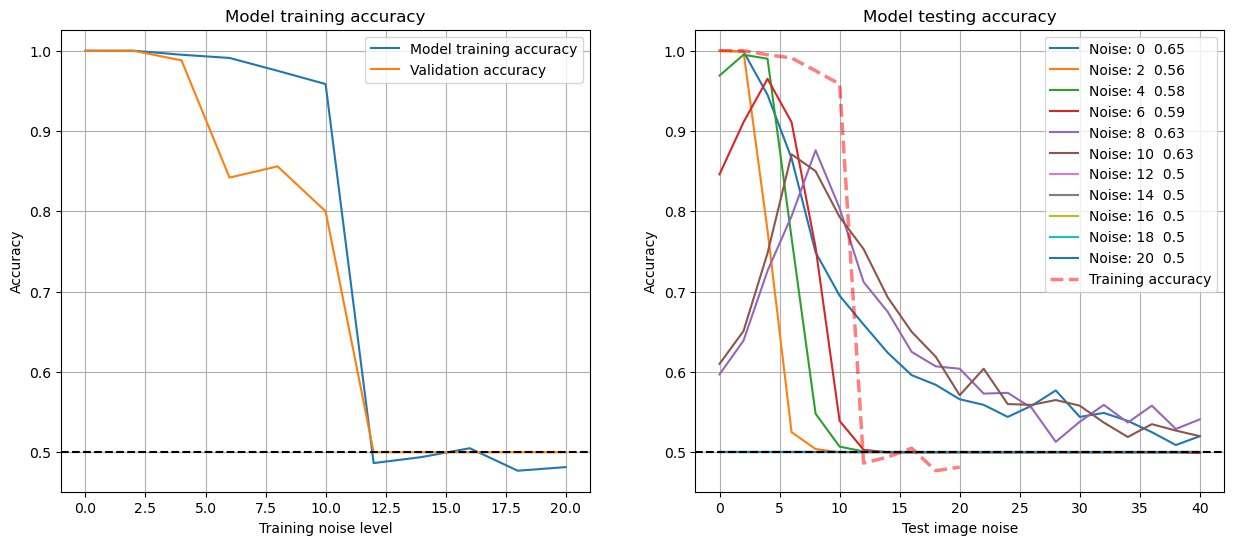

In [7]:
'''fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].grid()
for i, val in enumerate(noiselist):
    #ax[0].plot(noiselist, fptestacc[i], label=f'Trained on {val}')
    ax[1].plot(noiselist, testaccresults[i], label=f'Trained on {val}')
ax[0].set_xlabel('Image noise')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Model false positive accuracy')
ax[0].legend(loc='best')

ax[1].grid()
ax[1].set_xlabel('Test image noise')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Model testing accuracy')
ax[1].legend(loc='best')

y_pred = model2.predict(testingimages)
y_pred = y_pred.flatten()

# Convert predictions to binary labels (0 or 1)
y_pred_binary = np.round(y_pred, 0)
y_pred_binary = [int(i) for i in y_pred_binary]

# Calculate confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(testlabel, y_pred_binary)

# Extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = confusion_matrix.ravel()

# Calculate false positive rate (FPR) and false negative rate (FNR)

fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positive Rate:", fpr)
print("False Negative Rate:", fnr)'''
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize=(15,6))
for i, val in enumerate(noiselist):
    ax[1].plot(noiselist2, testaccresults[i], label=f'Noise: {val}  {np.average(testaccresults[i]):0.2}')

ax[0].plot(noiselist, trainaccresults, label='Model training accuracy')
ax[0].plot(noiselist, valaccresults, label='Validation accuracy')
ax[1].plot(noiselist, trainaccresults, c='r', ls='--', lw=2.5, label='Training accuracy', alpha=0.5)

ax[0].axhline(y=0.5, c='k', ls='--')
ax[0].set_title('Model training accuracy')
ax[0].set_xlabel('Training noise level')
ax[0].set_ylabel('Accuracy')
ax[0].grid()
ax[0].legend()

ax[1].set_title('Model testing accuracy')
ax[1].set_xlabel('Test image noise')
ax[1].set_ylabel('Accuracy')
ax[1].axhline(y=0.5, c='k', ls='--')
ax[1].grid()
ax[1].legend(loc='upper right')

### Discussion
As expected the model doesn't perform well above a noise level of 10 in either training or in testing. The model trained on clean neutrino images achieves a validation and test accuracy of 1.0 but this quickly falls to 0.5 at higher levels of noise. The best performing model is the one trained at a noise level of 10, maintaining an average test accuracy of 0.66, but this same model only has a test accuracy of 0.6 on clean neutrino images.

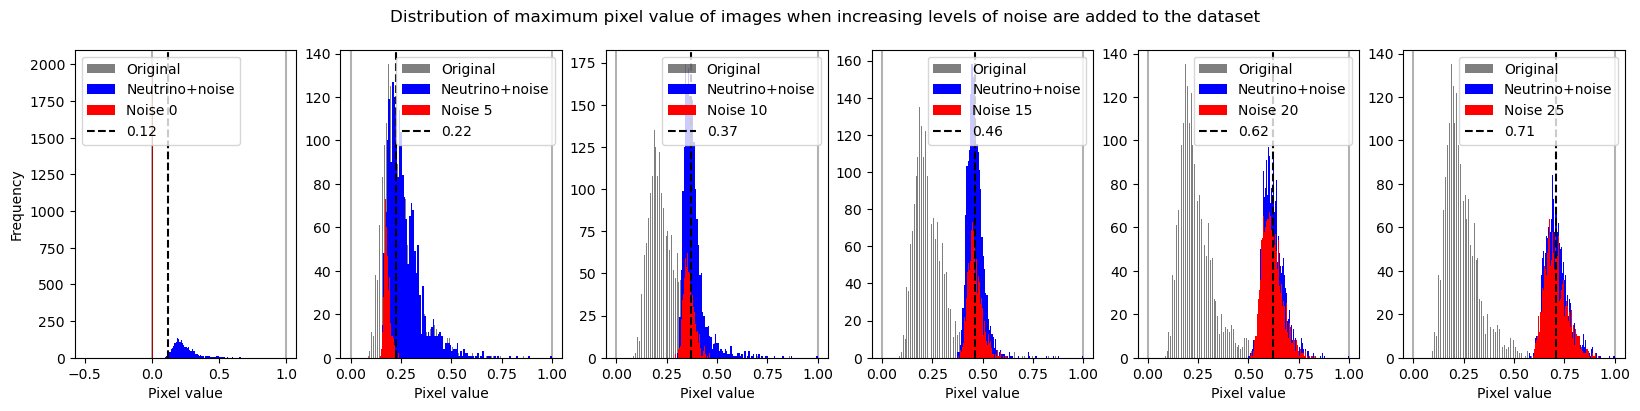

In [8]:
fig, ax = plt.subplots(1, 6, figsize = (20, 4))
for i, j in enumerate(np.arange(0,30,5)):
    trainingimages, trainlabel = trainingimgmaker(4000, True, j)
    plimg =  maxpixelvalue(trainingimgmaker(4000, True, 0)[0][0:2000])
    maxptrainimgol = maxpixelvalue(trainingimages[:2000])
    maxpnoiseimgol = maxpixelvalue(trainingimages[2000:])
    maxpol = maxpixelvalue(trainingimages)
    fig.suptitle('Distribution of maximum pixel value of images when increasing levels of noise are added to the dataset')
    ax[0].set_ylabel('Frequency')
    ax[i].axvline(x=0, c='k', ls='-', alpha=0.3)
    ax[i].axvline(x=1, c='k', ls='-', alpha=0.3)

    ax[i].hist(plimg, bins=200, color='k', label='Original', alpha=0.5)
    ax[i].hist(maxptrainimgol, bins=100, color='b', label='Neutrino+noise')
    ax[i].hist(maxpnoiseimgol, bins=100, color='r', label=f'Noise {j}')
    ax[i].axvline(np.mean(maxpol), c='k', ls='--', label=f'{np.mean(maxpol):2.2f}')
    ax[i].set_xlabel('Pixel value')
    ax[i].legend()

These plots are here to illustrate what is going on when noise is added to images. For low levels of noise, the neutrino images are largely unaffected, but as the noise level increases, the noise start to obscure the pixels in the neutrino images. As soon as the average maximum pixel value of noise exceed the average for neutrino images, the model cannot learn any useful information. The next model hopes to mitigate the effect that electronic noise has on the accuracy of a binary classifier by training a model on images with a variety of noise levels.

In [9]:
model3 = keras.models.clone_model(model2) 
model3.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
multinoiselist = np.arange(0,30,2)
multitrainimg = np.empty((0, 100,100))
multitrainlbl = []
finaltimg = np.empty((0, 100,100))
finaltl = []

multitestlossresults = []
multitestaccresults = []
multiconfusionresults = []

for i in range(15):
    temptrainimg, temptrainlbl = trainingimgmaker(200, True, i)
    multitrainimg= np.append(multitrainimg, temptrainimg, axis=0)
    multitrainlbl= np.append(multitrainlbl, temptrainlbl)

history = model3.fit(multitrainimg, multitrainlbl, epochs=30, verbose=1)

for i in noiselist2:
    finaltimgtemp, finaltltemp = trainingimgmaker(500, True, i)
    
    finaltl = np.append(finaltl, finaltltemp)
    finaltimg = np.append(finaltimg, finaltimgtemp, axis=0)
    loss, acc = model3.evaluate(finaltimgtemp, finaltltemp, verbose=1)
    multitestlossresults = np.append(multitestlossresults, loss)
    multitestaccresults = np.append(multitestaccresults, acc)
    y_pred = model3.predict(finaltimg)
    y_pred_binary = np.round(y_pred, 0)
    y_pred_binary = [int(i) for i in y_pred_binary]
    confusion_matrix = sklearn.metrics.confusion_matrix(finaltl, y_pred_binary)
    multiconfusionresults.append(confusion_matrix)
    finaltimg = np.empty((0, 100,100))
    finaltl = []

print(f'Model accuracy: ', history.history['accuracy'][-1])
print(f'Test accuracy: {acc}')

Epoch 1/30
94/94 [==============================] - 8s 66ms/step - loss: 0.6944 - accuracy: 0.4977
Epoch 2/30
94/94 [==============================] - 5s 49ms/step - loss: 0.6927 - accuracy: 0.5220
Epoch 3/30
94/94 [==============================] - 5s 48ms/step - loss: 0.5470 - accuracy: 0.7313
Epoch 4/30
94/94 [==============================] - 5s 48ms/step - loss: 0.3338 - accuracy: 0.8473
Epoch 5/30
94/94 [==============================] - 5s 49ms/step - loss: 0.2870 - accuracy: 0.8710
Epoch 6/30
94/94 [==============================] - 5s 48ms/step - loss: 0.2718 - accuracy: 0.8780
Epoch 7/30
94/94 [==============================] - 5s 48ms/step - loss: 0.2473 - accuracy: 0.8843
Epoch 8/30
94/94 [==============================] - 4s 48ms/step - loss: 0.2240 - accuracy: 0.9007
Epoch 9/30
94/94 [==============================] - 5s 52ms/step - loss: 0.2012 - accuracy: 0.9053
Epoch 10/30
94/94 [==============================] - 5s 56ms/step - loss: 0.1901 - accuracy: 0.9153
Epoch 11/

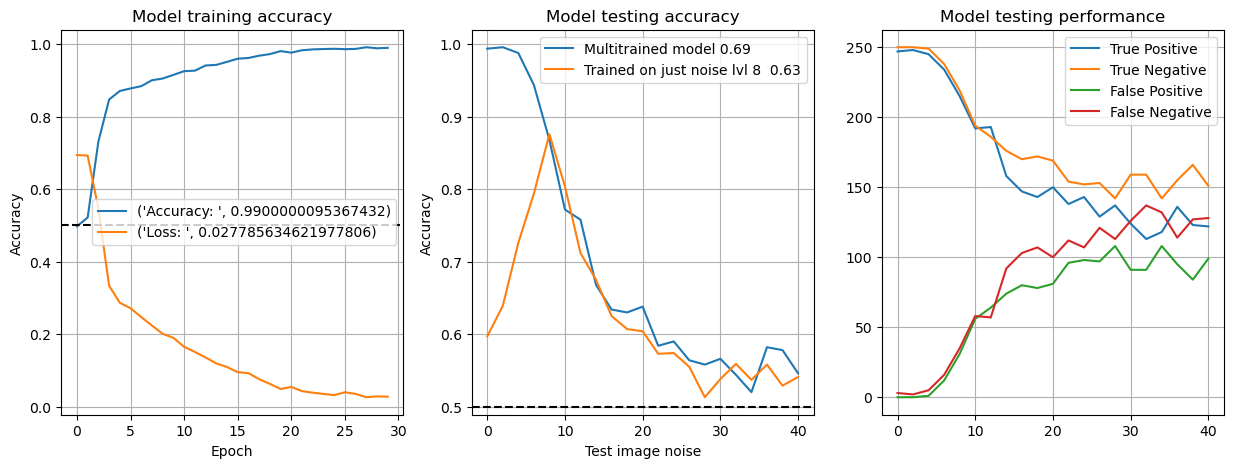

In [10]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(history.history['accuracy'],  label=('Accuracy: ',history.history['accuracy'][-1]))
ax[0].plot(history.history['loss'],  label=('Loss: ', history.history['loss'][-1]))

ax[0].axhline(y=0.5, c='k', ls='--')
ax[0].set_title('Model training accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid()

ax[1].plot(noiselist2, multitestaccresults, label=f'Multitrained model {np.average(multitestaccresults):0.2}')
ax[1].plot(noiselist2, testaccresults[4], label=f'Trained on just noise lvl 8  {np.average(testaccresults[4]):0.2}')
ax[1].set_title('Model testing accuracy')
ax[1].set_xlabel('Test image noise')
ax[1].set_ylabel('Accuracy')
ax[1].axhline(y=0.5, c='k', ls='--')
ax[1].grid()
ax[1].legend(loc='upper right')

tplist=[]
tnlist=[]
fplist=[]
fnlist=[]
for i in multiconfusionresults:
    tn, fp, fn, tp = i.ravel()
    tnlist.append(tn)
    tplist.append(tp)
    fplist.append(fp)
    fnlist.append(fn)
ax[2].set_title('Model testing performance')
ax[2].plot(noiselist2, tplist, label='True Positive')
ax[2].plot(noiselist2, tnlist, label='True Negative')
ax[2].plot(noiselist2, fplist, label='False Positive')
ax[2].plot(noiselist2, fnlist, label='False Negative')
ax[2].grid()
ax[2].legend()

This model is trained over 30 epochs and achieves a higher overall accuracy when testing over the same noise range (0 to 40) even though it has only been trained on a smaller noise range compared to the previous model. Again the testing accuracy of the model still drops as the level of noise is increased as the noise begins to obscure the relative pixel brightness in neutrino images 

### Potential extensions
1. Write a method to generate noise in the 100x100 pixel images to simulate radioactive noise. This noise should be in the form of randomly placed Gaussian 'blobs' with appropriate energy. Repeat the above tests with radioactive noise. Is radioactive noise more or less of a problem than electronic noise? 
2. Write a machine learning algorithm that can determine either the electron energy or (even better) the neutrino energy. What is the best energy resolution that can be achieved by such an algorithm?
3. Write a machine learning algorithm to effectively denoise either the electronic noise or radioactive noise datasets
4. Write a machine learning algorithm to determin the number of final state particles in the image

## Extension 1
1. Write a method to generate noise in the 100x100 pixel images to simulate radioactive noise. This noise should be in the form of randomly placed Gaussian 'blobs' with appropriate energy. Repeat the above tests with radioactive noise. Is radioactive noise more or less of a problem than electronic noise?

### Generating Gaussian blob noise
Liquid argon detectors can be contaminated by radioisotopes - typically low energy $\beta$ emitters like $^{39}Cl$, $^{39}Ar$ and $^{35}S$, which have decay energies of a few MeV or less. To simulate this behaviour the functions generate a 2D 100x100 array with a number of Gaussian 'blobs' each with a random position, size and height (intensity). The random distribution of height is centred around 5MeV, as this is 
### 2D Gaussian equation

$$f(x,y)=A \space exp\left({\frac{(x-x_0)^2+(y-y_0)^2}{2(\sigma_X^2+\sigma^2_Y)}}\right)$$

(9, 100, 100)


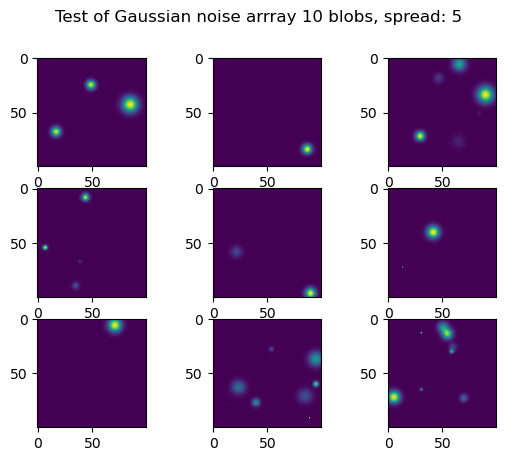

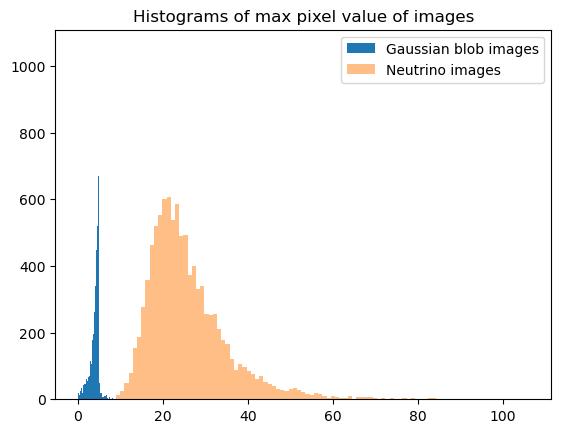

In [11]:
def generate_radioactive_noise(max_num_blobs, spread):
    '''
    This function generates a single 100x100 array with randomly positioned Gaussian blobs in them
    The height of the Gaussian blobs are determined by the variable spread and are generated based on a uniform dist.

    Inputs
    - num_blobs - maximum number of blobs to generate
    - spread - how varied the height (brightness) of the blobs are

    Outputs
    - Image - single 2D image array with Gaussian blobs in it
    '''
    image = np.zeros((100, 100))
    
    for i in range(np.random.randint(0,max_num_blobs)):
        # Randomly generate the position and size of the blob
        x0 = np.random.randint(0, 100)
        y0 = np.random.randint(0, 100)
        size = np.random.uniform(0, 5)  # Random size of the blob
        height = np.random.uniform(0, spread)  # Random energy of the blob
        
        # Generarate a Gaussian blob centered at (x, y) with the specified size and energy
        yy, xx = np.mgrid[:100, :100]
        blob = np.exp(-((xx - x0) ** 2 + (yy - y0) ** 2) / (2 * size ** 2)) * height
        
        # Add the blob to the image
        image += blob.clip(min=0)
    
    return image

def blobarraymaker(num, blobno, spread):
    '''
    This function generates an array of 100x100 images with randomly positioned Gaussian blobs in them

    Inputs
    - num - number of images to generate
    - num_blobs - maximum number of blobs to generate per image
    - spread - increases the range that blob height (brightness) can be

    Outputs
    - justnoise - array pf images with Gaussian blobs in it
    '''
    justnoise=np.zeros([num, 100, 100])
    for i in range(num):
        justnoise[i] = generate_radioactive_noise(blobno, spread)
    return justnoise

# Example usage:
num_blobs = 10
spread = 5

radioactive_noise_image = generate_radioactive_noise(num_blobs, spread)
testarray = blobarraymaker(9, 10, 5)
print(testarray.shape)

# Display the generated radioactive noise image
fig, axs = plt.subplots(3,3)
fig.suptitle(f'Test of Gaussian noise arrray {num_blobs} blobs, spread: {spread}')
for ax, arr in zip(axs.flat, testarray):
    ax.imshow(arr)

plt.show()
radiomaxp = maxpixelvalue(blobarraymaker(10000, 10, 5))
plt.title('Histograms of max pixel value of images')
plt.hist(radiomaxp, bins=100, label='Gaussian blob images')
plt.hist(max_values, bins=100, alpha=0.5, label='Neutrino images')
plt.legend()


### Discussion
The histogram illustrates that the simulated radioactive noise will hardly affect the neutrino images at a $\sigma=5$ level. The training and testing in the next section is carried out at a $\sigma=20$ level.

In [12]:
def blobtrainingimgmaker(numofimg, numofb, spread):
    '''
    This function generates an array of 100x100 images with the first half neutrino images with Gaussian noise overlaid and the second half
    just Gaussian noise

    Inputs
    - numofimg - size of array to generate
    - numofb - maximum number of blobs to generate per image
    - spread - how varied the height (intensity) of the blobs are

    Outputs
    - traininimages - array of generated images
    - trainlabels - associated binary label for each image
    '''
    numoftrimgs = int(numofimg/2)
    trainlabel=np.append(np.ones(numoftrimgs), np.zeros(numoftrimgs))
    trainlabel = [int(i) for i in trainlabel]
    trainlabel = np.array(trainlabel)

    imgsample = imagesample(numoftrimgs)

    if numofb == 0:
        trainingimages = np.append(minmaxnorm(imgsample), np.zeros((numoftrimgs, 100,100)), axis=0)
        return trainingimages, trainlabel
    else:
        trimgwnoise = imgsample+blobarraymaker(numoftrimgs, numofb, spread)
        trnoisearray = blobarraymaker(numoftrimgs, numofb, spread)
        trainingimages = minmaxnorm(np.append(trimgwnoise, trnoisearray, axis=0))
        return  trainingimages, trainlabel

# Setting up the model
blobmodel = keras.models.clone_model(model2)

#compiles network
blobmodel.compile(keras.optimizers.Adam(learning_rate=1e-3),loss='binary_crossentropy',metrics=['accuracy'])

numofblobs = np.arange(0,51,5)
blobtrainacc=[]
for i in numofblobs:
    print('Max number of blobs:', i)
    trainingimages, trainlabel = blobtrainingimgmaker(2000, i, 20)
    '''fig,ax=plt.subplots(1,3)
    ax0 = ax[0].imshow(trainingimages[500], vmin=0, vmax=np.max(trainingimages[500]))
    ax1 = ax[1].imshow(trainingimages[1500], vmin=0, vmax=np.max(trainingimages[500]))
    tempmaxp=maxpixelvalue(trainingimages)
    ax[2].hist(tempmaxp[1000:], bins=100, label='Gaussian blob images')
    ax[2].hist(tempmaxp[:1000], bins=100, alpha=0.5, label='Neutrino images')
    plt.show()'''
    blobmodel.compile(keras.optimizers.Adam(learning_rate=1e-3),loss='binary_crossentropy',metrics=['accuracy'])
    history = blobmodel.fit(trainingimages, trainlabel, epochs=3, verbose=1)
    print('Model acc:' ,history.history['accuracy'][-1])
    blobtrainacc.append(history.history['accuracy'][-1])

Max number of blobs: 0
Epoch 1/3
63/63 [==============================] - 4s 43ms/step - loss: 0.4111 - accuracy: 0.8425
Epoch 2/3
63/63 [==============================] - 3s 43ms/step - loss: 0.0687 - accuracy: 0.9975
Epoch 3/3
63/63 [==============================] - 3s 43ms/step - loss: 0.0198 - accuracy: 1.0000
Model acc: 1.0
Max number of blobs: 5
Epoch 1/3
63/63 [==============================] - 4s 44ms/step - loss: 2.0696 - accuracy: 0.8840
Epoch 2/3
63/63 [==============================] - 3s 43ms/step - loss: 0.1391 - accuracy: 0.9695
Epoch 3/3
63/63 [==============================] - 3s 43ms/step - loss: 0.0603 - accuracy: 0.9810
Model acc: 0.9810000061988831
Max number of blobs: 10
Epoch 1/3
63/63 [==============================] - 4s 43ms/step - loss: 0.0373 - accuracy: 0.9910
Epoch 2/3
63/63 [==============================] - 3s 43ms/step - loss: 0.0177 - accuracy: 0.9945
Epoch 3/3
63/63 [==============================] - 3s 43ms/step - loss: 0.0061 - accuracy: 0.9975
Mod

In [13]:
radtestlossresults = []
radtestaccresults = []
numofblobt = np.arange(0,100,2)
for i in numofblobt:
    print('Max number of blobs:', i)
    testradimg, testradlbl = blobtrainingimgmaker(500, i, 20)
    loss, acc = blobmodel.evaluate(testradimg, testradlbl)
    radtestlossresults = np.append(radtestlossresults, loss)
    radtestaccresults = np.append(radtestaccresults, acc)


Max number of blobs: 0
16/16 [==============================] - 0s 14ms/step - loss: 0.0012 - accuracy: 1.0000
Max number of blobs: 2
16/16 [==============================] - 0s 14ms/step - loss: 0.0011 - accuracy: 1.0000
Max number of blobs: 4
16/16 [==============================] - 0s 14ms/step - loss: 0.0010 - accuracy: 1.0000
Max number of blobs: 6
16/16 [==============================] - 0s 14ms/step - loss: 0.0035 - accuracy: 1.0000
Max number of blobs: 8
16/16 [==============================] - 0s 14ms/step - loss: 0.0016 - accuracy: 1.0000
Max number of blobs: 10
16/16 [==============================] - 0s 14ms/step - loss: 0.0039 - accuracy: 0.9980
Max number of blobs: 12
16/16 [==============================] - 0s 14ms/step - loss: 0.0028 - accuracy: 0.9980
Max number of blobs: 14
16/16 [==============================] - 0s 14ms/step - loss: 0.0191 - accuracy: 0.9940
Max number of blobs: 16
16/16 [==============================] - 0s 16ms/step - loss: 0.0187 - accuracy: 0.99

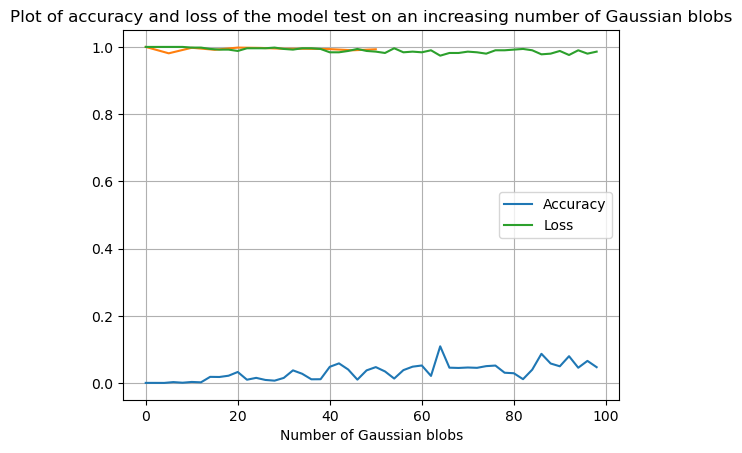

In [14]:
plt.title('Plot of accuracy and loss of the model test on an increasing number of Gaussian blobs')
plt.plot(numofblobt, radtestlossresults, label='Accuracy')
plt.plot(numofblobs, blobtrainacc)
plt.plot(numofblobt, radtestaccresults, label='Loss')
plt.xlabel('Number of Gaussian blobs')
plt.grid()
plt.legend()

### Discussion
It can be seen that to affect the model’s accuracy will require a large amount of Gaussian blobs to be added to the image, as the accuracy remains very high when 100 blobs are added, even at a higher σ level of 20.

## Extension 2 - Reconstructing electron energies
2. Write a machine learning algorithm that can determine either the electron energy or (even better) the neutrino energy. What is the best energy resolution that can be achieved by such an algorithm?

In [15]:
# Quick test of how the data shape of meta works
'''count=0
for i in meta:
    print(f'Row {int(i[0])}, {int(i[2])} initial particles')
    for j in range(2):
        print(f'IP {j} is {i[4+(5*j)]} at index {4+(5*j)}')
    print(f'Row {int(i[0])}, {int(i[3])} final particles')
    for j in range(int(i[3])):
        print(f'FP {j+1} is {i[14+(5*j)]} at index {14+(5*j)}')
        if int(i[14+(5*j)]) == 11 and j==0:
            count+=1
    print('\n')
print(count)
print(np.max(meta[:,1]))'''

"count=0\nfor i in meta:\n    print(f'Row {int(i[0])}, {int(i[2])} initial particles')\n    for j in range(2):\n        print(f'IP {j} is {i[4+(5*j)]} at index {4+(5*j)}')\n    print(f'Row {int(i[0])}, {int(i[3])} final particles')\n    for j in range(int(i[3])):\n        print(f'FP {j+1} is {i[14+(5*j)]} at index {14+(5*j)}')\n        if int(i[14+(5*j)]) == 11 and j==0:\n            count+=1\n    print('\n')\nprint(count)\nprint(np.max(meta[:,1]))"

In regression tasks, accuracy is not an appropriate metric for evaluation because accuracy is typically used for classification tasks where predictions are discrete labels. In 
regression, where you're predicting continuous values (like energy levels), accuracy doesn't make sense.

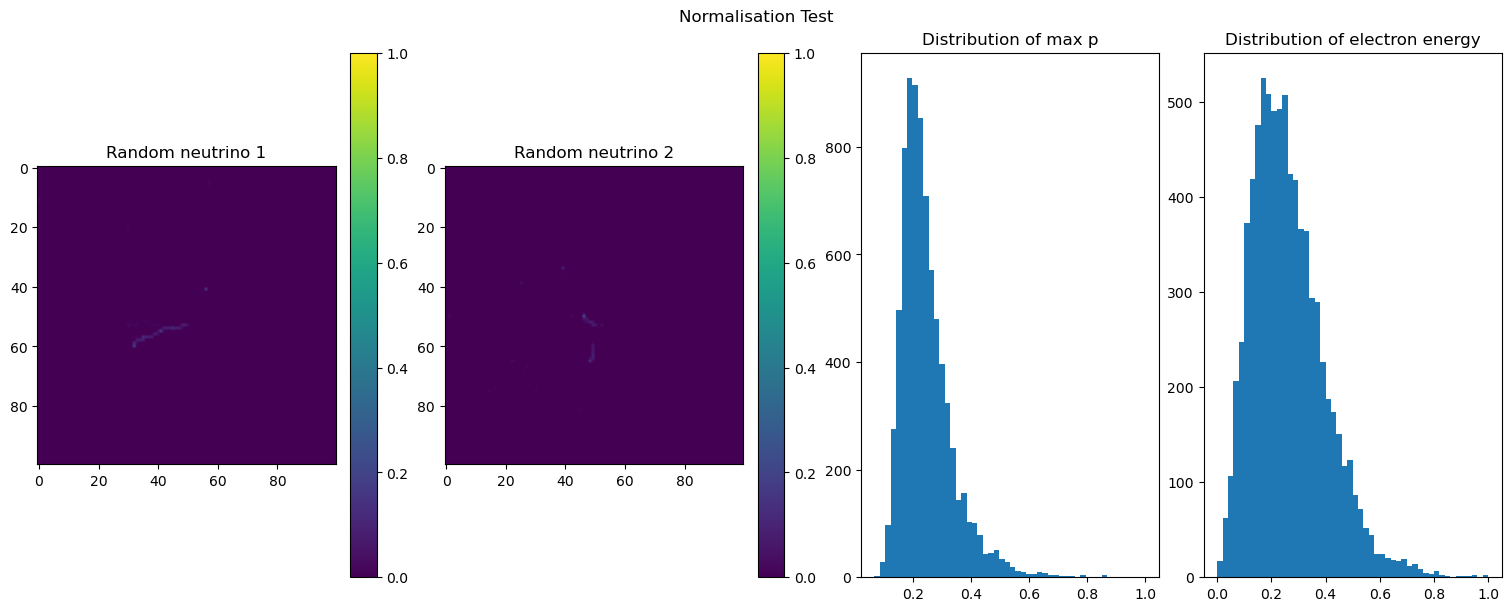

Epoch 1/5
250/250 [==============================] - 297s 1s/step - loss: 0.0120
Epoch 2/5
250/250 [==============================] - 321s 1s/step - loss: 0.0049
Epoch 3/5
250/250 [==============================] - 347s 1s/step - loss: 0.0044
Epoch 4/5
250/250 [==============================] - 284s 1s/step - loss: 0.0040
Epoch 5/5
250/250 [==============================] - 266s 1s/step - loss: 0.0043


In [16]:
#Take slice of neutrino images
ereconimg = images[0:8000]
ereconimgnorm = minmaxnorm(ereconimg)
ereconlble = []
ereconlbln = []

# This loop creates the associated electron and neutrino energy label for each image
for i in meta[0:8000]:
    ereconlble.append(i[15])
    ereconlbln.append(i[1])
ereconlblenorm = minmaxnorm(ereconlble)
ereconlblnnorm = minmaxnorm(ereconlbln)

#Repeat for test images
ereconimgtest = images[9000:]
ereconimgtestnorm = minmaxnorm(ereconimgtest)
ereconlbletest = []
ereconlblntest = []

# This loop creates the associated electron and neutrino energy label for each image
for i in meta[9000:]:
    ereconlbletest.append(i[15])
    ereconlblntest.append(i[1])
ereconlbletestnorm = minmaxnorm(ereconlbletest)
ereconlblntestnorm = minmaxnorm(ereconlblntest)


fig, ax = plt.subplots(1,4, figsize=(15,6), constrained_layout=True)
fig.suptitle('Normalisation Test')

im1 = ax[0].imshow(ereconimgnorm[np.random.randint(0,500)], vmax=np.max(ereconimgnorm))
ax[0].set_title(f'Random neutrino 1')

im2 = ax[1].imshow(ereconimgnorm[np.random.randint(501, 1000)], vmax=np.max(ereconimgnorm))
ax[1].set_title('Random neutrino 2')
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])

ereconimgmax = maxpixelvalue(ereconimgnorm)
ax[2].set_title('Distribution of max p')
ax[2].hist(ereconimgmax, bins=50)

ax[3].set_title('Distribution of electron energy')
ax[3].hist(ereconlblenorm, bins=50)
plt.show()

# Define the model
ereconmodel = keras.models.Sequential()
ereconmodel.add(keras.layers.Conv2D(128, 3, activation='relu', input_shape=(100,100,1)))
ereconmodel.add(keras.layers.MaxPooling2D((2, 2)))

ereconmodel.add(keras.layers.Conv2D(512, 3, activation='relu'))#
ereconmodel.add(keras.layers.MaxPooling2D((2, 2)))

ereconmodel.add(keras.layers.Conv2D(64, 3, activation='relu'))#
ereconmodel.add(keras.layers.MaxPooling2D((2, 2)))

ereconmodel.add(keras.layers.Flatten())
ereconmodel.add(keras.layers.Dense(128,activation='relu'))
ereconmodel.add(keras.layers.Dropout(0.3))
ereconmodel.add(keras.layers.Dense(128,activation='relu'))

ereconmodel.add(keras.layers.Dense(2, activation='sigmoid'))

# Compile the model with appropriate loss functions for each output
ereconmodel.compile(optimizer='adam', loss='mse')

ereconmodel.fit(ereconimgnorm, [ereconlblenorm, ereconlblnnorm], epochs=5)

In [17]:

# Assuming y_true and y_pred are your true and predicted labels, respectively
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = ereconmodel.predict(ereconimgtestnorm)
y_prede = np.transpose(y_pred)[0]
y_predn = np.transpose(y_pred)[1]

realprede = y_prede * (np.max(ereconlbletest) - np.min(ereconlbletest)) + np.min(ereconlbletest)
realpredn = y_predn * (np.max(ereconlblntest) - np.min(ereconlblntest)) + np.min(ereconlblntest)

# Compute mean squared error
# Electron
msee = mean_squared_error(ereconlbletestnorm, y_prede) #Normalised
rmsee = mean_squared_error(ereconlbletest, realprede) #Scaled

# Neutrino
msen = mean_squared_error(ereconlblntestnorm, y_predn) #Normalised
rmsen = mean_squared_error(ereconlblntest, realpredn) #Scaled

# Compute mean absolute error
# Electron
maee = mean_absolute_error(ereconlbletestnorm, y_prede) #Normalised
rmaee = mean_absolute_error(ereconlbletest, realprede) #Scaled

# Neutrino
maen = mean_absolute_error(ereconlblntestnorm, y_predn) #Normalised
rmaen = mean_absolute_error(ereconlblntest, realpredn) #Scaled

# Compute R² score
# Electron
r2e = r2_score(ereconlbletestnorm, y_prede) #Normalised
rr2e = r2_score(ereconlbletest, realprede) #Scaled

# Neutrino
r2n = r2_score(ereconlblntestnorm, y_predn) #Normalised
rr2n = r2_score(ereconlblntest, realpredn) #Scaled


# Compute root mean squared error
# Normalised
rmsee = np.sqrt(msee)
rmsen = np.sqrt(msen)

# Scaled
rrmsee = np.sqrt(rmsee)
rrmsen = np.sqrt(rmsen)

32/32 [==============================] - 11s 316ms/step



Normalised

Electron energy
Mean Squared Error: 0.005587375226372627
Mean Absolute Error: 0.04843294717967659
R² Score: 0.7935629008121021
Root Mean Squared Error: 0.07474874732309984

Neutrino energy
Mean Squared Error: 0.014265948652397466
Mean Absolute Error: 0.0779903395600951
R² Score: 0.5404883999354498
Root Mean Squared Error: 0.11944014673633596


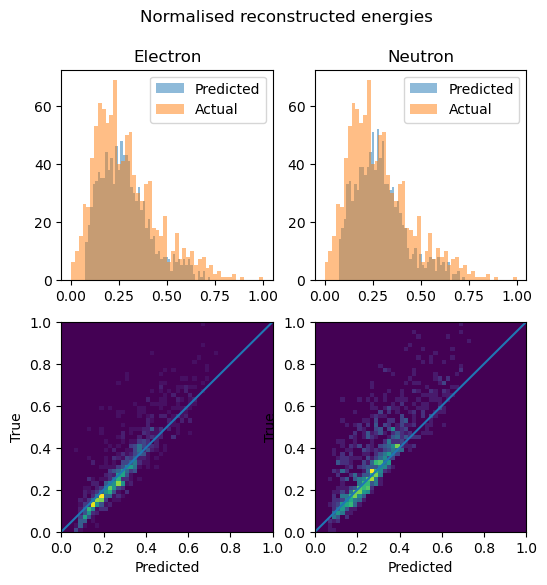


Scaled

Electron energy
Mean Squared Error: 0.07474874732309984
Mean Absolute Error: 2.3624279972488402
R² Score: 0.7935628966413184
Root Mean Squared Error: 0.2734021713942664

Neutrino energy
Mean Squared Error: 0.11944014673633596
Mean Absolute Error: 3.7748290500283814
R² Score: 0.5404884301178152
Root Mean Squared Error: 0.3456011382162043


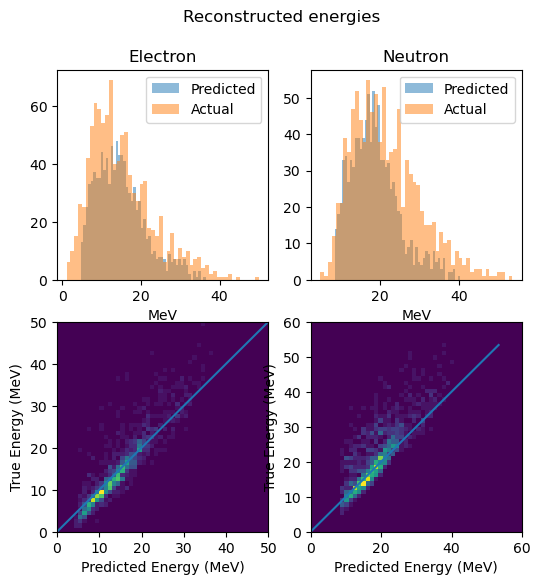

In [18]:
#Plotting 2d histogram of the predicted and true values of the models
print('\nNormalised\n')
print('Electron energy')
print("Mean Squared Error:", msee)
print("Mean Absolute Error:", maee)
print("R² Score:", r2e)
print("Root Mean Squared Error:", rmsee)

print('\nNeutrino energy')
print("Mean Squared Error:", msen)
print("Mean Absolute Error:", maen)
print("R² Score:", r2n)
print("Root Mean Squared Error:", rmsen)

fig, ax = plt.subplots(2, 2, figsize=(6,6))
fig.suptitle('Normalised reconstructed energies')
ax[0][0].set_title('Electron')
ax[0][0].hist(y_prede, bins=50, label='Predicted', alpha=0.5)
ax[0][0].hist(ereconlbletestnorm, bins=50, label='Actual', alpha=0.5)
ax[0][0].legend()

ax[0][1].set_title('Neutron')
ax[0][1].hist(y_predn, bins=50, label='Predicted', alpha=0.5)
ax[0][1].hist(ereconlbletestnorm, bins=50, label='Actual', alpha=0.5)
ax[0][1].legend()

ax[1][0].hist2d(y_prede, ereconlbletestnorm, bins=(50,50), range=[[0, 1], [0, 1]])
ax[1][0].plot(np.linspace(0,1 ,2),np.linspace(0,1 ,2) )
ax[1][0].set_xlabel('Predicted')
ax[1][0].set_ylabel('True')

ax[1][1].hist2d(y_predn, ereconlblntestnorm, bins=(50,50), range=[[0, 1], [0, 1]])
ax[1][1].plot(np.linspace(0,1 ,2),np.linspace(0,1 ,2) )
ax[1][1].set_xlabel('Predicted')
ax[1][1].set_ylabel('True')
plt.show()

print('\nScaled\n')
print('Electron energy')
print("Mean Squared Error:", rmsee)
print("Mean Absolute Error:", rmaee)
print("R² Score:", rr2e)
print("Root Mean Squared Error:", rrmsee)

print('\nNeutrino energy')
print("Mean Squared Error:", rmsen)
print("Mean Absolute Error:", rmaen)
print("R² Score:", rr2n)
print("Root Mean Squared Error:", rrmsen)

fig, ax = plt.subplots(2, 2, figsize=(6,6))
fig.suptitle('Reconstructed energies')
ax[0][0].set_title('Electron')
ax[0][0].set_title('Electron')
ax[0][0].hist(realprede, bins=50, label='Predicted', alpha=0.5)
ax[0][0].hist(ereconlbletest, bins=50, label='Actual', alpha=0.5)
ax[0][0].set_xlabel('MeV')
ax[0][0].legend()

ax[0][1].set_title('Neutron')
ax[0][1].hist(realpredn, bins=50, label='Predicted', alpha=0.5)
ax[0][1].hist(ereconlblntest, bins=50, label='Actual', alpha=0.5)
ax[0][1].set_xlabel('MeV')
ax[0][1].legend()

ax[1][0].hist2d(realprede, ereconlbletest, bins=(50,50), range=[[0, 50], [0, 50]])
ax[1][0].plot(np.linspace(0,np.max(ereconlbletest),2),np.linspace(0,np.max(ereconlbletest),2) )
ax[1][0].set_xlabel('Predicted Energy (MeV)')
ax[1][0].set_ylabel('True Energy (MeV)')

ax[1][1].hist2d(realpredn, ereconlblntest, bins=(50,50), range=[[0, 60], [0, 60]])
ax[1][1].plot(np.linspace(0,np.max(ereconlblntest),2),np.linspace(0,np.max(ereconlblntest),2) )
ax[1][1].set_xlabel('Predicted Energy (MeV)')
ax[1][1].set_ylabel('True Energy (MeV)')
plt.show()

I accidently pressed run out of order too soon to the deadline  so this is the graphic I used in my report. The code should work if you run it in order but here's what should appear.
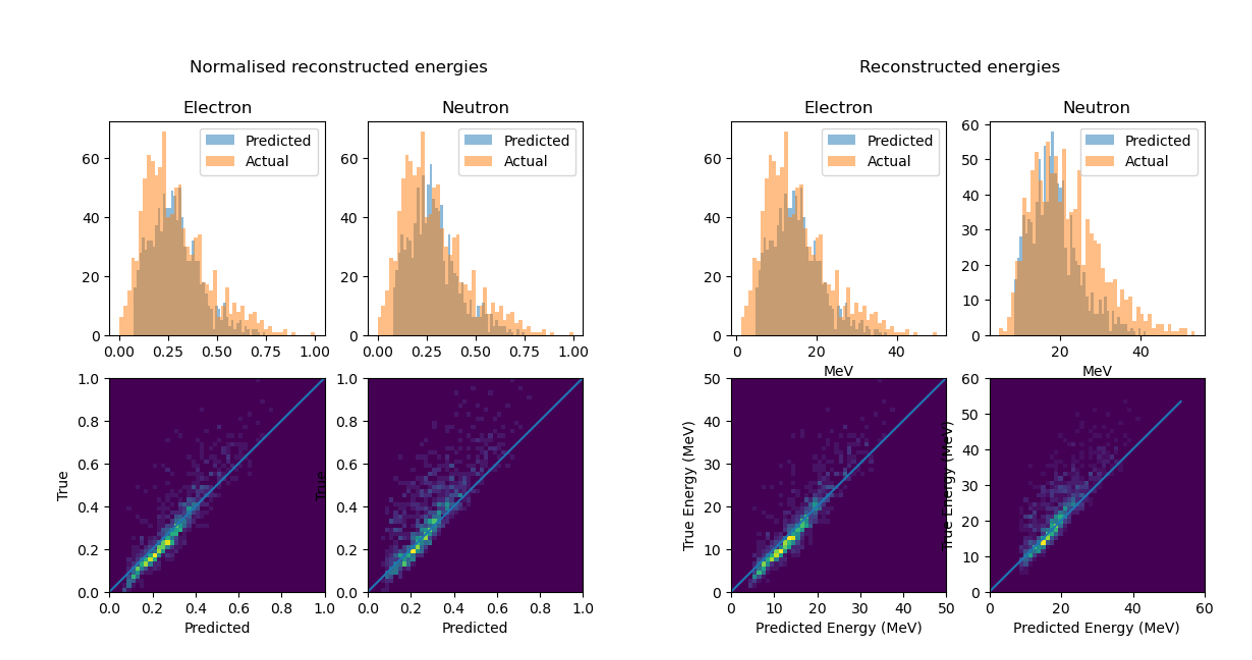

## References

[1] H.-T. Janka, “Neutrino Emission from Supernovae,” Handbook of Supernovae, pp. 1575–1604, 2017, doi: https://doi.org/10.1007/978-3-319-21846-5_4.

[2] K. Scholberg, “Supernova neutrino detection,” Journal of Physics: Conference Series, vol. 375, no. 4, p. 042036, Jul. 2012, doi: https://doi.org/10.1088/1742-6596/375/1/042036.

[3] IceCube Collaboration et al., “IceCube Sensitivity for Low-Energy Neutrinos from Nearby Supernovae,” Astronomy & Astrophysics, vol. 535, p. A109, Nov. 2011, doi: https://doi.org/10.1051/0004-6361/201117810.

[4] M. Turner, “BakeryScan and Cyto-AiSCAN,” Medium, Nov. 13, 2021. https://towardsdatascience.com/bakeryscan-and-cyto-aiscan-52475b3cb779

[5] S. WASSWA, “How Convolutional Neural Networks Work.,” wasswa-sam.netlify.app, Feb. 16, 2016. https://wasswa-sam.netlify.app/deeplearning/2017/02/26/how-convnets-work.html (accessed Mar. 20, 2024).

[6] A. Amidi and S. Amidi, “The evolution of image classification explained,” Stanford.edu, 2012. https://stanford.edu/~shervine/blog/evolution-image-classification-explained

[7] A. Krizhevsky, I. Sutskever, and G. E. Hinton, “ImageNet Classification with Deep Convolutional Neural Networks,” Communications of the ACM, vol. 60, no. 6, pp. 84–90, May 2012, doi: https://doi.org/10.1145/3065386.

[8] R. Acciarri et al., “Noise Characterization and Filtering in the MicroBooNE Liquid Argon TPC,” Journal of Instrumentation, vol. 12, no. 08, pp. P08003–P08003, Aug. 2017, doi: https://doi.org/10.1088/1748-0221/12/08/p08003.

[9] Melanie, “Convolutional Neural Network: Everything You Need to Know,” Data Science Courses | DataScientest, Sep. 10, 2023. https://datascientest.com/en/convolutional-neural-network-everything-you-need-to-know

[10] P. Baldi, J. Bian, L. Hertel, and L. Li, “Improved energy reconstruction in NOvA with regression convolutional neural networks,” Physical review, vol. 99, no. 1, Jan. 2019, doi: https://doi.org/10.1103/physrevd.99.012011.